In [3]:
import torchvision 
from torchvision import transforms
from torch.utils.data import DataLoader
import torch as ch
import torch.nn as nn
import math
import matplotlib.pyplot as plt
import cox
from cox.utils import Parameters
import cox.store as store
from cox.readers import CollectionReader
import seaborn as sns
import os
import seaborn as sns
import matplotlib.pyplot as plt

# set environment variable so that stores can create output files
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

TRUNC_CE_CONSTANT_LR = '/home/gridsan/stefanou/cifar-10/resnet-18/trunc_constant_test/'
TRUNC_CE_CYCLIC = '/home/gridsan/stefanou/cifar-10/resnet-18/trunc_ce_cyclic_100epochs'
TRUNC_CE_COSINE = '/home/gridsan/stefanou/cifar-10/resnet-18/trunc_ce_cosine_100epochs'
TRUNC_CE_STEP_LR_REAL = '/home/gridsan/stefanou/cifar-10/resnet-18/trunc_ce_step_lr_real_200epochs'

CE_CONSTANT_LR = '/home/gridsan/stefanou/cifar-10/resnet-18/ce_constant_100epochs'
CE_CYCLIC = '/home/gridsan/stefanou/cifar-10/resnet-18/ce_cyclic_100epochs'
CE_COSINE = '/home/gridsan/stefanou/cifar-10/resnet-18/ce_cosine_100epochs'
CE_STEP_LR_REAL = '/home/gridsan/stefanou/cifar-10/resnet-18/ce_step_lr_real_200epochs'

TRUNC_CE_STEP_LR = '/home/gridsan/stefanou/cifar-10/resnet-18/trunc_ce_step_lr'
CE_STEP_LR = '/home/gridsan/stefanou/cifar-10/resnet-18/ce_step_lr'

CE_CONSTANT_VARY_EPOCHS = '/home/gridsan/stefanou/cifar-10/resnet-18/ce_constant_vary_epochs'
TRUNC_CE_CONSTANT_VARY_EPOCHS = '/home/gridsan/stefanou/cifar-10/resnet-18/trunc_ce_constant_vary_epochs'

CE_CONSTANT_VARY_EPOCHS_AND_LR = '/home/gridsan/stefanou/cifar-10/resnet-18/ce_step_lr_real_vary_epochs_and_lr'
TRUNC_CE_CONSTANT_VARY_EPOCHS_AND_LR = '/home/gridsan/stefanou/cifar-10/resnet-18/trunc_ce_step_lr_vary_epochs_and_lr'

LR = [5e-1, 3e-1, 2e-1, 1e-1, 1e-2]
EPOCHS = [50, 100, 150, 200]

In [70]:
def plot(ce_metadata, ce_logs, trunc_metadata, trunc_logs, type_):
    fig = plt.figure()
    fig.set_figheight(10)
    fig.set_figwidth(15)
    for i, lr in enumerate(LR):
        ce_exp_id = ce_metadata[ce_metadata['lr'] == lr]['exp_id']
        ce_exp_logs = ce_logs[ce_logs.exp_id.isin(ce_exp_id)]

        trunc_exp_id = trunc_metadata[trunc_metadata['lr'] == lr]['exp_id']
        trunc_exp_logs = trunc_logs[trunc_logs.exp_id.isin(trunc_exp_id)]

        fig.add_subplot(2, 5, i + 1)
        sns.lineplot(data=ce_exp_logs, x='epoch', y='train_loss', label='ce train')
        sns.lineplot(data=ce_exp_logs, x='epoch', y='val_loss', label='ce val')

        sns.lineplot(data=trunc_exp_logs, x='epoch', y='train_loss', label='trunc ce train')
        sns.lineplot(data=trunc_exp_logs, x='epoch', y='val_loss', label='trunc val')
        plt.title('{} LR: {} Loss Curves'.format(type_, lr))

        fig.add_subplot(2, 5, i + 6)

        sns.lineplot(data=ce_exp_logs, x='epoch', y='train_prec1', label='ce train')
        sns.lineplot(data=ce_exp_logs, x='epoch', y='val_prec1', label='ce val')

        sns.lineplot(data=trunc_exp_logs, x='epoch', y='train_prec1', label='trunc ce train')
        sns.lineplot(data=trunc_exp_logs, x='epoch', y='val_prec1', label='trunc val')
        plt.title('{} LR: {} Prec1 Curves'.format(type_, lr))
    plt.tight_layout()
    plt.show()
    
    
def plot_(ce_unseen, trunc_unseen, ce_test, trunc_test, ce_metadata, trunc_metadata): 
    fig = plt.figure()
    fig.set_figheight(5)
    fig.set_figwidth(15)
    
    fig.add_subplot(1, 2, 1)
    trunc_unseen['lr'] = trunc_unseen.apply(lambda row: trunc_metadata[trunc_metadata.exp_id == row.exp_id]['lr'], axis=1)
    ce_unseen['lr'] = ce_unseen.apply(lambda row: ce_metadata[ce_metadata.exp_id == row.exp_id]['lr'], axis=1)

    sns.lineplot(data=ce_unseen, x='lr', y='test_prec1', label='ce')
    sns.lineplot(data=trunc_unseen, x='lr', y='test_prec1', label='trunc')
    plt.xlabel('lr')
    plt.ylabel('Accuracy')
    plt.title('Unseen Dataset Accuracy')
    
    fig.add_subplot(1, 2, 2)
    trunc_test['lr'] = trunc_test.apply(lambda row: trunc_metadata[trunc_metadata.exp_id == row.exp_id]['lr'], axis=1)
    ce_test['lr'] = ce_test.apply(lambda row: ce_metadata[ce_metadata.exp_id == row.exp_id]['lr'], axis=1)

    sns.lineplot(data=ce_test, x='lr', y='test_prec1', label='ce')
    sns.lineplot(data=trunc_test, x='lr', y='test_prec1', label='trunc')
    plt.xlabel('lr')
    plt.ylabel('Accuracy')
    plt.title('Test Dataset Accuracy')
    plt.tight_layout()

100%|██████████| 15/15 [00:00<00:00, 45.23it/s]


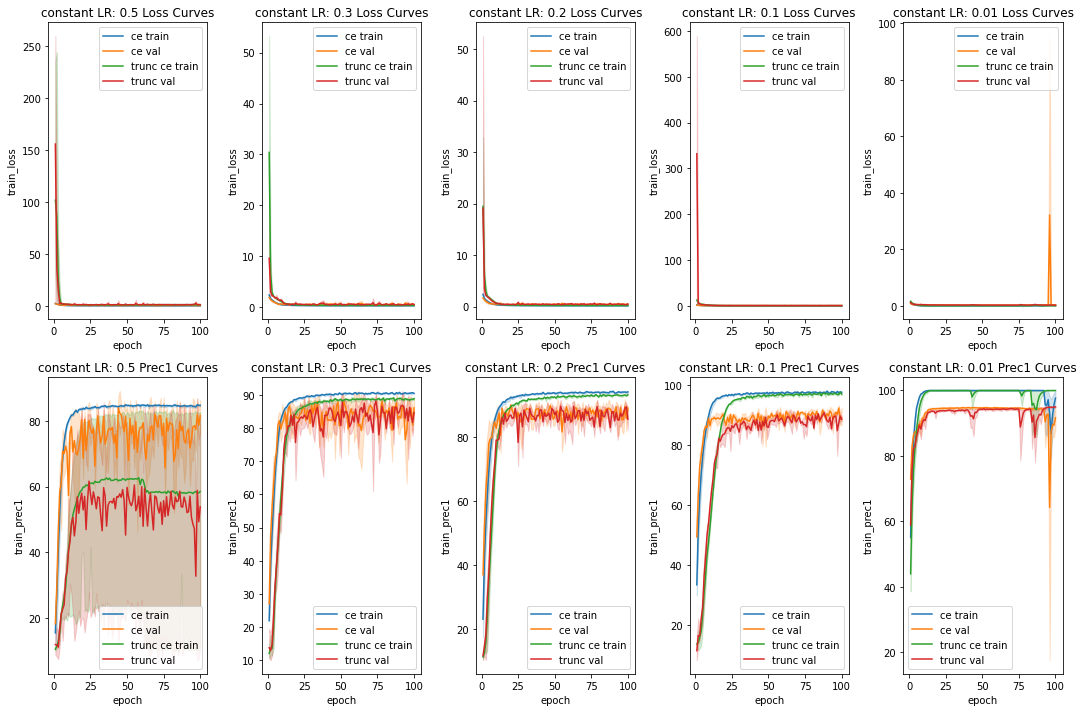

In [52]:
constant_ce_reader = CollectionReader(CE_CONSTANT_LR)
constant_trunc_reader = CollectionReader(TRUNC_CE_CONSTANT_LR)

constant_ce_logs, constant_trunc_logs = constant_ce_reader.df('logs'), constant_trunc_reader.df('logs')
constant_ce_metadata, constant_trunc_metadata = constant_ce_reader.df('metadata'), constant_trunc_reader.df('metadata')

plot(constant_ce_metadata, constant_ce_logs, constant_trunc_metadata, constant_trunc_logs, 'constant')

constant_ce_reader.close()
constant_trunc_reader.close()

100%|██████████| 15/15 [00:00<00:00, 42.62it/s]


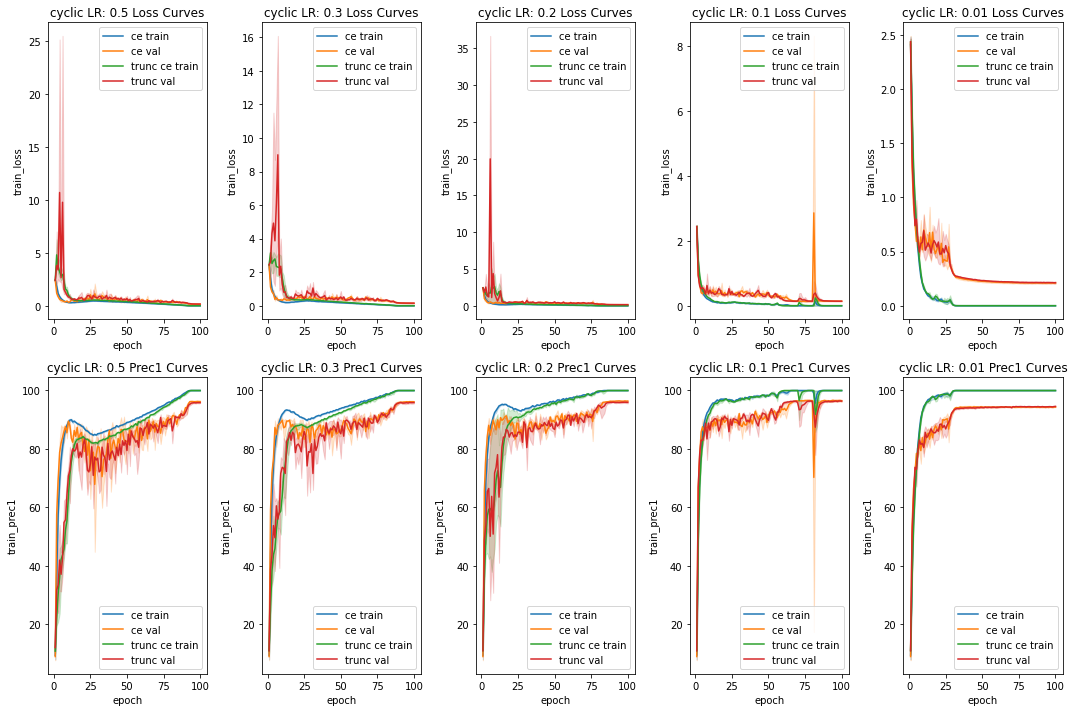

In [34]:
cyclic_ce_reader = CollectionReader(CE_CYCLIC)
cyclic_trunc_reader = CollectionReader(TRUNC_CE_CYCLIC)

cyclic_ce_logs, cyclic_trunc_logs = cyclic_ce_reader.df('logs'), cyclic_trunc_reader.df('logs')
cyclic_ce_metadata, cyclic_trunc_metadata = cyclic_ce_reader.df('metadata'), cyclic_trunc_reader.df('metadata')

plot(cyclic_ce_metadata, cyclic_ce_logs, cyclic_trunc_metadata, cyclic_trunc_logs, 'cyclic')

cyclic_ce_reader.close()
cyclic_trunc_reader.close()

100%|██████████| 15/15 [00:00<00:00, 42.94it/s]


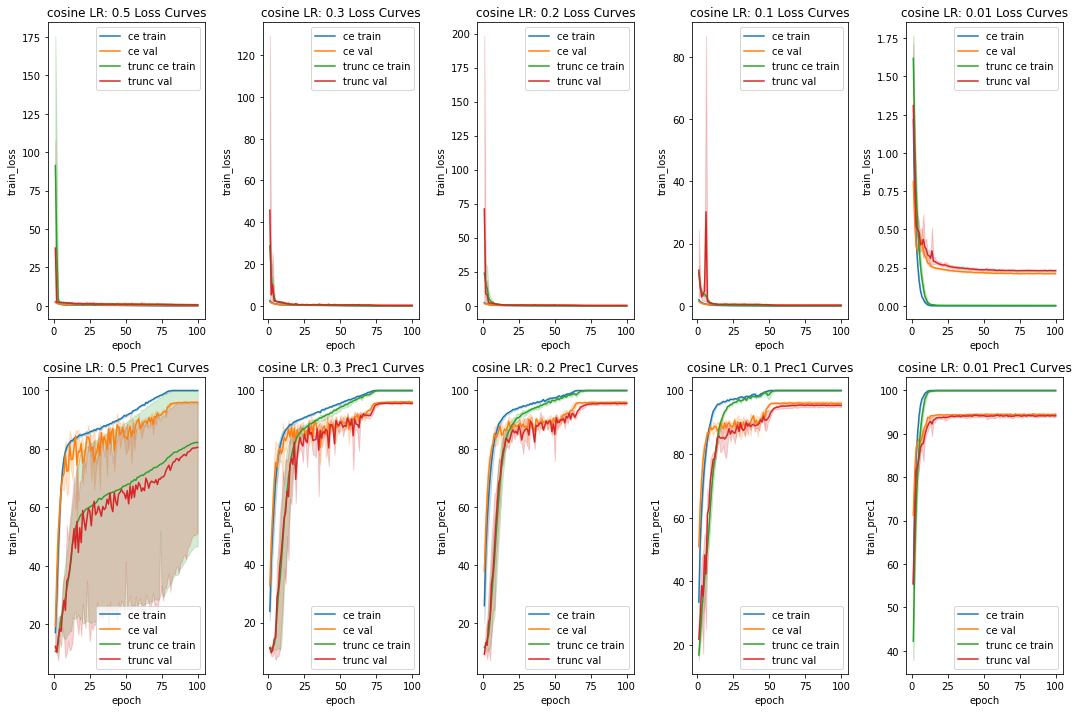

In [35]:
cosine_ce_reader = CollectionReader(CE_COSINE)
cosine_trunc_reader = CollectionReader(TRUNC_CE_COSINE)

cosine_ce_logs, cosine_trunc_logs = cosine_ce_reader.df('logs'), cosine_trunc_reader.df('logs')
cosine_ce_metadata, cosine_trunc_metadata = cosine_ce_reader.df('metadata'), cosine_trunc_reader.df('metadata')

plot(cosine_ce_metadata, cosine_ce_logs, cosine_trunc_metadata, cosine_trunc_logs, 'cosine')

cosine_ce_reader.close()
cosine_trunc_reader.close()

100%|██████████| 11/11 [00:00<00:00, 42.88it/s]


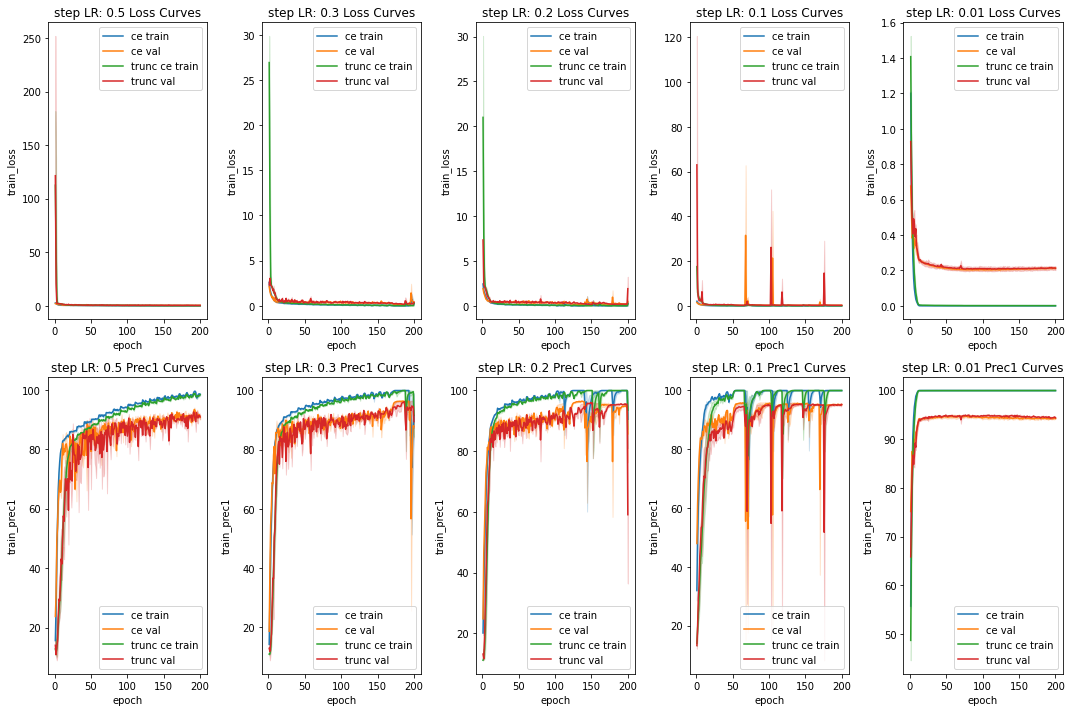

In [63]:
step_ce_reader = CollectionReader(CE_STEP_LR_REAL)
step_trunc_reader = CollectionReader(TRUNC_CE_STEP_LR_REAL)

step_ce_logs, step_trunc_logs = step_ce_reader.df('logs'), step_trunc_reader.df('logs')
step_ce_metadata, step_trunc_metadata = step_ce_reader.df('metadata'), step_trunc_reader.df('metadata')

plot(step_ce_metadata, step_ce_logs, step_trunc_metadata, step_trunc_logs, 'step')

step_ce_reader.close()
step_trunc_reader.close()

100%|██████████| 16/16 [00:01<00:00, 11.63it/s]


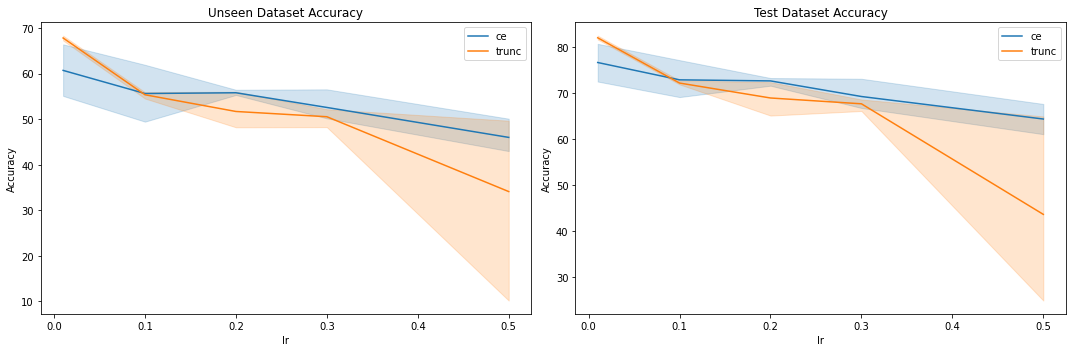

In [64]:
constant_ce_reader = CollectionReader(CE_CONSTANT_LR)
constant_trunc_reader = CollectionReader(TRUNC_CE_CONSTANT_LR)

constant_ce_unseen, constant_trunc_unseen = constant_ce_reader.df('unseen'), constant_trunc_reader.df('unseen')
constant_ce_test, constant_trunc_test = constant_ce_reader.df('test'), constant_trunc_reader.df('test')
constant_ce_metadata, constant_trunc_metadata = constant_ce_reader.df('metadata'), constant_trunc_reader.df('metadata')

plot_(constant_ce_unseen, constant_trunc_unseen, constant_ce_test, constant_trunc_test, constant_ce_metadata, constant_trunc_metadata)

constant_ce_reader.close()
constant_trunc_reader.close()

100%|██████████| 15/15 [00:01<00:00, 10.87it/s]


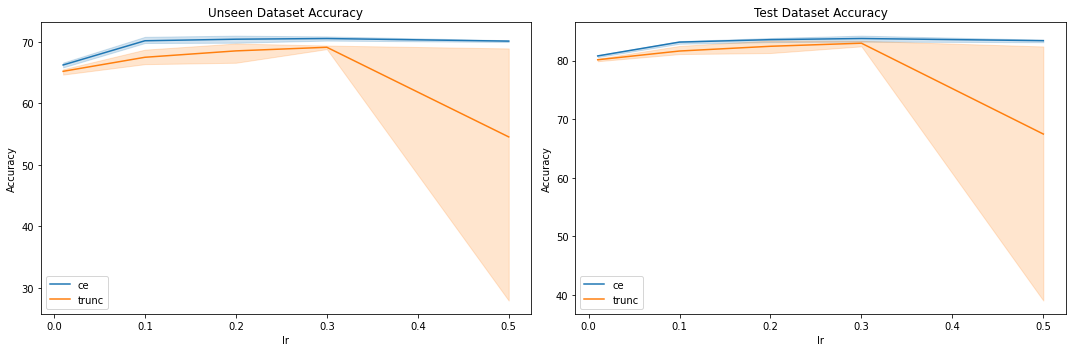

In [65]:
cosine_ce_reader = CollectionReader(CE_COSINE)
cosine_trunc_reader = CollectionReader(TRUNC_CE_COSINE)

cosine_ce_unseen, cosine_trunc_unseen = cosine_ce_reader.df('unseen'), cosine_trunc_reader.df('unseen')
cosine_ce_test, cosine_trunc_test = cosine_ce_reader.df('test'), cosine_trunc_reader.df('test')
cosine_ce_metadata, cosine_trunc_metadata = cosine_ce_reader.df('metadata'), cosine_trunc_reader.df('metadata')

plot_(cosine_ce_unseen, cosine_trunc_unseen, cosine_ce_test, cosine_trunc_test, cosine_ce_metadata, cosine_trunc_metadata)

cosine_ce_reader.close()
cosine_trunc_reader.close()

100%|██████████| 11/11 [00:07<00:00,  1.45it/s]


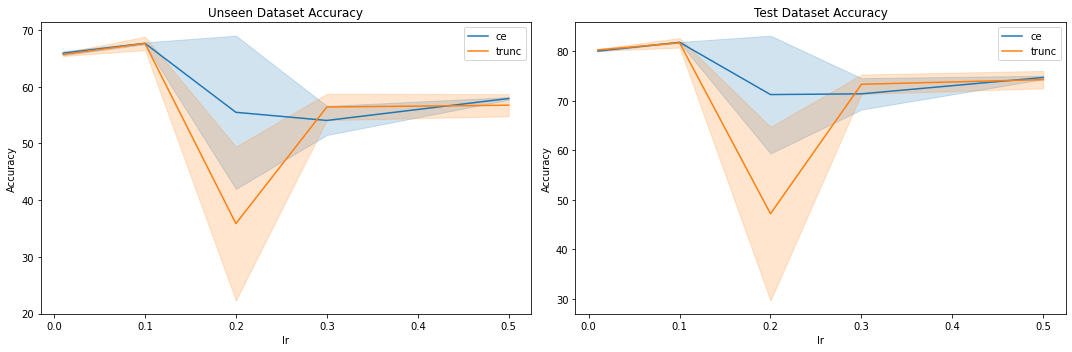

In [62]:
step_ce_reader = CollectionReader(CE_STEP_LR_REAL)
step_trunc_reader = CollectionReader(TRUNC_CE_STEP_LR_REAL)

step_ce_unseen, step_trunc_unseen = step_ce_reader.df('unseen'), step_trunc_reader.df('unseen')
step_ce_test, step_trunc_test = step_ce_reader.df('test'), step_trunc_reader.df('test')
step_ce_metadata, step_trunc_metadata = step_ce_reader.df('metadata'), step_trunc_reader.df('metadata')

plot_(step_ce_unseen, step_trunc_unseen, step_ce_test, step_trunc_test, step_ce_metadata, step_trunc_metadata)

step_ce_reader.close()
step_trunc_reader.close()

100%|██████████| 15/15 [00:01<00:00, 10.10it/s]


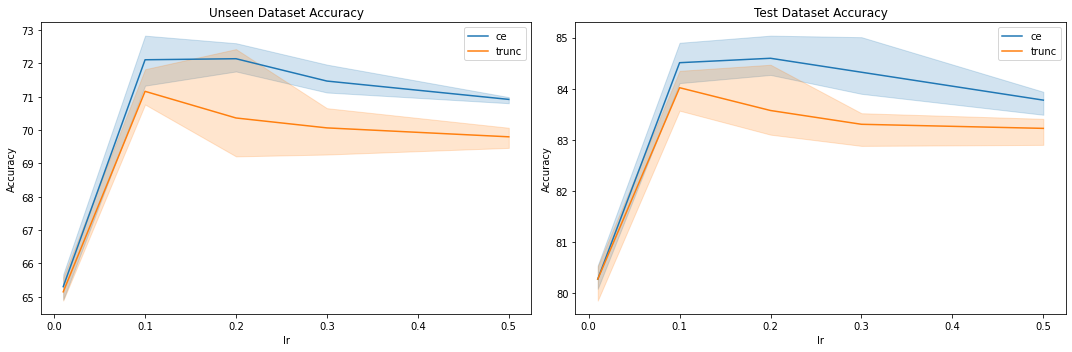

In [61]:
cyclic_ce_reader = CollectionReader(CE_CYCLIC)
cyclic_trunc_reader = CollectionReader(TRUNC_CE_CYCLIC)

cyclic_ce_unseen, cyclic_trunc_unseen = cyclic_ce_reader.df('unseen'), cyclic_trunc_reader.df('unseen')
cyclic_ce_test, cyclic_trunc_test = cyclic_ce_reader.df('test'), cyclic_trunc_reader.df('test')
cyclic_ce_metadata, cyclic_trunc_metadata = cyclic_ce_reader.df('metadata'), cyclic_trunc_reader.df('metadata')

plot_(cyclic_ce_unseen, cyclic_trunc_unseen, cyclic_ce_test, cyclic_trunc_test, cyclic_ce_metadata, cyclic_trunc_metadata)

cyclic_ce_reader.close()
cyclic_trunc_reader.close()

In [75]:
ce_constant_vary_epochs_reader = CollectionReader(CE_CONSTANT_VARY_EPOCHS)
trunc_ce_constant_vary_epochs_reader = CollectionReader(TRUNC_CE_CONSTANT_VARY_EPOCHS)

ce_logs, trunc_logs = ce_constant_vary_epochs_reader.df('logs'), trunc_ce_constant_vary_epochs_reader.df('logs')
ce_metadata, trunc_metadata = ce_constant_vary_epochs_reader.df('metadata'), trunc_ce_constant_vary_epochs_reader.df('metadata')

ce_unseen, trunc_unseen = ce_constant_vary_epochs_reader.df('unseen'), trunc_ce_constant_vary_epochs_reader.df('unseen')
ce_test, trunc_test = ce_constant_vary_epochs_reader.df('test'), trunc_ce_constant_vary_epochs_reader.df('test')
ce_metadata, trunc_metadata = ce_constant_vary_epochs_reader.df('metadata'), trunc_ce_constant_vary_epochs_reader.df('metadata')

ce_constant_vary_epochs_reader.close()
trunc_ce_constant_vary_epochs_reader.close()


100%|██████████| 5/5 [00:00<00:00,  9.48it/s]


In [77]:
ce_constant_vary_epochs_reader.close()

In [78]:
ce_logs

,epoch,val_prec1,val_loss,train_prec1,train_loss,time,exp_id
0,1,76.978142,0.634166,56.184494,1.192342,9.995147,0e417e79-38c6-41bb-b4d8-53194c71fd1d
1,2,75.546341,0.719320,77.190948,0.635854,20.443737,0e417e79-38c6-41bb-b4d8-53194c71fd1d
2,3,88.470230,0.347005,85.654297,0.409553,29.974528,0e417e79-38c6-41bb-b4d8-53194c71fd1d
3,4,86.247169,0.442547,90.707039,0.260490,40.486332,0e417e79-38c6-41bb-b4d8-53194c71fd1d
4,5,87.942726,0.443600,94.855072,0.146779,55.171275,0e417e79-38c6-41bb-b4d8-53194c71fd1d
...,...,...,...,...,...,...,...
95,96,89.638283,0.299243,91.208900,0.253604,1015.509305,02810ab2-0aba-4254-8951-0818cdfc4bfa
96,97,89.261490,0.337124,94.858490,0.153265,1025.713825,02810ab2-0aba-4254-8951-0818cdfc4bfa
97,98,92.162773,0.275437,97.203918,0.088775,1035.195620,02810ab2-0aba-4254-8951-0818cdfc4bfa
98,99,89.562920,0.412824,98.432968,0.052223,1045.754375,02810ab2-0aba-4254-8951-0818cdfc4bfa


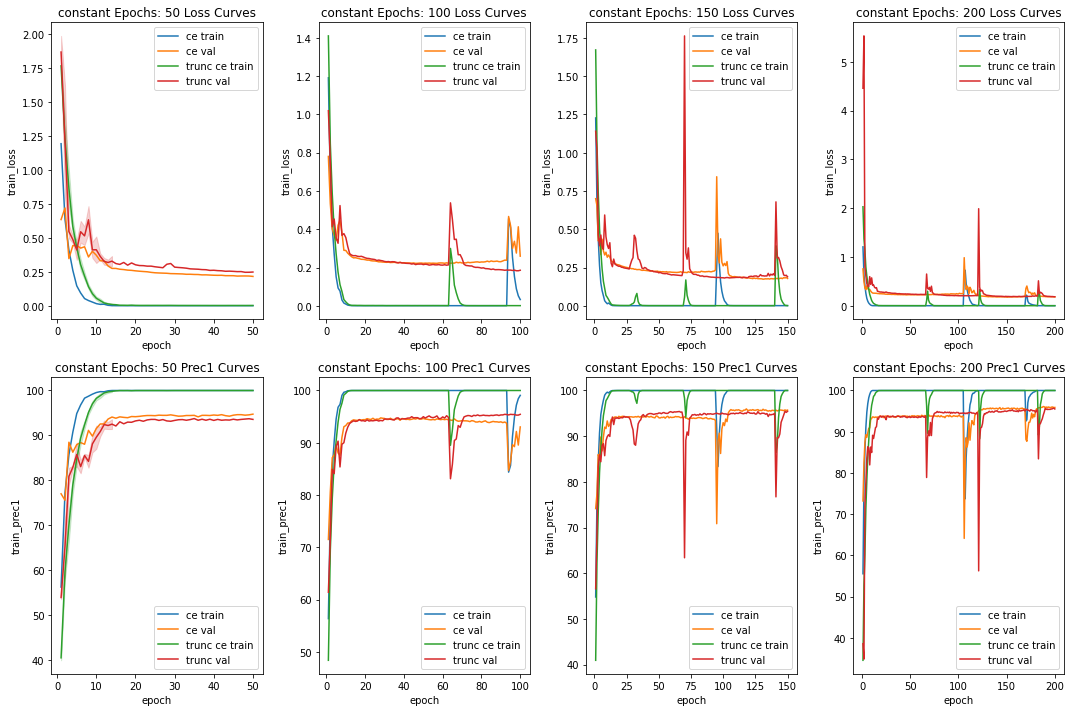

In [83]:
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(15)
for i, eps in enumerate(EPOCHS): 
    ce_exp_id = ce_metadata[ce_metadata['epochs'] == eps]['exp_id']
    ce_exp_logs = ce_logs[ce_logs.exp_id.isin(ce_exp_id)]
    
    trunc_exp_id = trunc_metadata[trunc_metadata['epochs'] == eps]['exp_id']
    trunc_exp_logs = trunc_logs[trunc_logs.exp_id.isin(trunc_exp_id)]
    
    fig.add_subplot(2, 4, i + 1)
    sns.lineplot(data=ce_exp_logs, x='epoch', y='train_loss', label='ce train')
    sns.lineplot(data=ce_exp_logs, x='epoch', y='val_loss', label='ce val')
    
    sns.lineplot(data=trunc_exp_logs, x='epoch', y='train_loss', label='trunc ce train')
    sns.lineplot(data=trunc_exp_logs, x='epoch', y='val_loss', label='trunc val')
    plt.title('{} Epochs: {} Loss Curves'.format('constant', eps))

    fig.add_subplot(2, 4, i + 5)

    sns.lineplot(data=ce_exp_logs, x='epoch', y='train_prec1', label='ce train')
    sns.lineplot(data=ce_exp_logs, x='epoch', y='val_prec1', label='ce val')

    sns.lineplot(data=trunc_exp_logs, x='epoch', y='train_prec1', label='trunc ce train')
    sns.lineplot(data=trunc_exp_logs, x='epoch', y='val_prec1', label='trunc val')
    plt.title('{} Epochs: {} Prec1 Curves'.format('constant', eps))
plt.tight_layout()
plt.show()

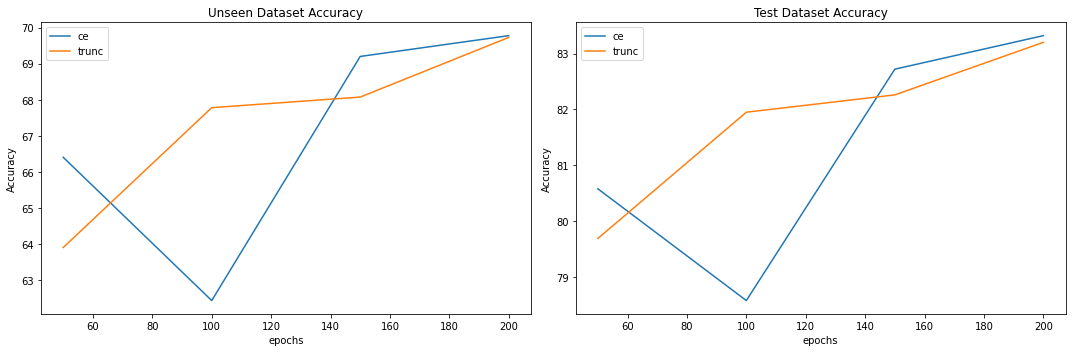

In [89]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(15)

fig.add_subplot(1, 2, 1)
trunc_unseen['epochs'] = trunc_unseen.apply(lambda row: trunc_metadata[trunc_metadata.exp_id == row.exp_id]['epochs'], axis=1)
ce_unseen['epochs'] = ce_unseen.apply(lambda row: ce_metadata[ce_metadata.exp_id == row.exp_id]['epochs'], axis=1)

sns.lineplot(data=ce_unseen, x='epochs', y='test_prec1', label='ce')
sns.lineplot(data=trunc_unseen, x='epochs', y='test_prec1', label='trunc')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.title('Unseen Dataset Accuracy')

fig.add_subplot(1, 2, 2)
trunc_test['epochs'] = trunc_test.apply(lambda row: trunc_metadata[trunc_metadata.exp_id == row.exp_id]['epochs'], axis=1)
ce_test['epochs'] = ce_test.apply(lambda row: ce_metadata[ce_metadata.exp_id == row.exp_id]['epochs'], axis=1)

sns.lineplot(data=ce_test, x='epochs', y='test_prec1', label='ce')
sns.lineplot(data=trunc_test, x='epochs', y='test_prec1', label='trunc')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.title('Test Dataset Accuracy')
plt.tight_layout()

In [112]:
ce_step_lr_tune_reader = CollectionReader(CE_CONSTANT_VARY_EPOCHS_AND_LR)
trunc_ce_step_lr_tune_reader = CollectionReader(TRUNC_CE_CONSTANT_VARY_EPOCHS_AND_LR)

ce_logs, trunc_logs = ce_step_lr_tune_reader.df('logs'), trunc_ce_step_lr_tune_reader.df('logs')
ce_metadata, trunc_metadata = ce_step_lr_tune_reader.df('metadata'), trunc_ce_step_lr_tune_reader.df('metadata')

ce_unseen, trunc_unseen = ce_step_lr_tune_reader.df('unseen'), trunc_ce_step_lr_tune_reader.df('unseen')
ce_test, trunc_test = ce_step_lr_tune_reader.df('test'), trunc_ce_step_lr_tune_reader.df('test')
ce_metadata, trunc_metadata = ce_step_lr_tune_reader.df('metadata'), trunc_ce_step_lr_tune_reader.df('metadata')

ce_step_lr_tune_reader.close()
trunc_ce_step_lr_tune_reader.close()


100%|██████████| 6/6 [00:00<00:00, 41.19it/s]


In [ ]:
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(15)
# enumerate over epochs for parameter tuning
for i, eps in enumerate(EPOCHS): 
    # select exp ids for number of epochs and then retrieve logs 
    ce_exp_id = ce_metadata[ce_metadata['epochs'] == eps]['exp_id']
    ce_exp_logs = ce_logs[ce_logs.exp_id.isin(ce_exp_id)]
        
    # select exp ids for number of epochs and then retrieve logs 
    trunc_exp_id = trunc_metadata[trunc_metadata['epochs'] == eps]['exp_id']
    trunc_exp_logs = trunc_logs[trunc_logs.exp_id.isin(trunc_exp_id)]
    
    # plot figures
    fig.add_subplot(2, 4, i + 1)
    sns.lineplot(data=ce_exp_logs, x='epoch', y='train_loss', label='ce train')
    sns.lineplot(data=ce_exp_logs, x='epoch', y='val_loss', label='ce val')
    
    sns.lineplot(data=trunc_exp_logs, x='epoch', y='train_loss', label='trunc ce train')
    sns.lineplot(data=trunc_exp_logs, x='epoch', y='val_loss', label='trunc val')
    plt.title('{} Epochs: {} Loss Curves'.format('constant', eps))

    fig.add_subplot(2, 4, i + 5)

    sns.lineplot(data=ce_exp_logs, x='epoch', y='train_prec1', label='ce train')
    sns.lineplot(data=ce_exp_logs, x='epoch', y='val_prec1', label='ce val')

    sns.lineplot(data=trunc_exp_logs, x='epoch', y='train_prec1', label='trunc ce train')
    sns.lineplot(data=trunc_exp_logs, x='epoch', y='val_prec1', label='trunc val')
    plt.title('{} Epochs: {} Prec1 Curves'.format('constant', eps))
plt.tight_layout()
plt.show()

In [96]:
ce_logs.head()

,epoch,val_prec1,val_loss,train_prec1,train_loss,time,exp_id
0,1,20.648077,1.998348,16.578470,2.643978,9.812415,ae852686-e879-41ae-a5af-fa3e2ce3b362
1,2,44.235115,1.491798,31.630877,1.790324,19.134836,ae852686-e879-41ae-a5af-fa3e2ce3b362
2,3,45.177090,1.443507,45.723942,1.438283,28.556576,ae852686-e879-41ae-a5af-fa3e2ce3b362
3,4,59.834209,1.055340,55.013485,1.210015,37.931681,ae852686-e879-41ae-a5af-fa3e2ce3b362
4,5,73.360962,0.737669,63.924072,0.986438,47.243034,ae852686-e879-41ae-a5af-fa3e2ce3b362


In [99]:
ce_metadata.head()

,workers,batch_size,accuracy,momentum,weight_decay,save_ckpt_iters,should_save_ckpt,log_iters,validation_split,shuffle,...,num_samples,logit_ball,trials,step_lr,step_lr_gamma,device,epochs,lr,version,exp_id
0,8,128,True,0.9,0.0005,10,True,1,0.8,True,...,1000,7.5,3,10,0.9,cuda,100,0.20,3c8823baff379d8f5bef347a609af66a75465410,ae852686-e879-41ae-a5af-fa3e2ce3b362
0,8,128,True,0.9,0.0005,10,True,1,0.8,True,...,1000,7.5,3,10,0.9,cuda,100,0.10,3c8823baff379d8f5bef347a609af66a75465410,5861592d-dc3b-4090-bb46-19b2e33b7f27
0,8,128,True,0.9,0.0005,10,True,1,0.8,True,...,1000,7.5,3,10,0.9,cuda,150,0.20,3c8823baff379d8f5bef347a609af66a75465410,cdce5a08-c0fe-444b-8516-404daee39328
0,8,128,True,0.9,0.0005,10,True,1,0.8,True,...,1000,7.5,3,10,0.9,cuda,100,0.01,3c8823baff379d8f5bef347a609af66a75465410,0260515f-190b-4751-81ca-b26aad229344
0,8,128,True,0.9,0.0005,10,True,1,0.8,True,...,1000,7.5,3,10,0.9,cuda,150,0.10,3c8823baff379d8f5bef347a609af66a75465410,0522c44b-0408-4472-9261-3538b19c041a


In [117]:
ce_metadata[ce_metadata['lr'] == 1e-1 and ce_metadata['epochs'] == 100]

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [114]:
ce_metadata['epochs']

0    100
0    100
0    150
0    100
0    150
Name: epochs, dtype: int64

In [109]:
data = ce_logs[ce_logs.exp_id.isin(exp_ids)]

<AxesSubplot:xlabel='epoch', ylabel='train_loss'>

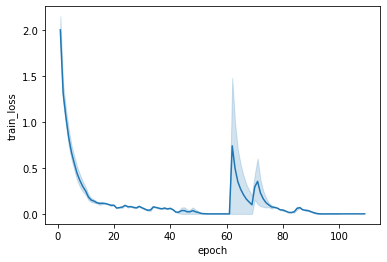

In [107]:
sns.lineplot(data=dat, x='epoch', y='train_loss')

In [123]:
trunc_unseen, trunc_test

(   test_prec1  test_loss      time                                exp_id
 0   66.446968   1.183678  1.957159  6f456647-1e8e-4430-8dc7-ba0a6ca299f9
 0   57.247303   1.687718  1.906589  3526f5f6-e0d4-434d-9deb-5807b3835334
 0   65.599556   1.174859  1.939237  abf7cd2b-ec90-433e-9b9f-798459d2ef03
 0   58.604267   1.403996  1.936369  1a9b02c1-8751-4730-8ec5-d86abde13dbe
 0   68.911659   1.062700  1.923484  8c270fff-58c7-4f62-97f6-27eb76987914,
    test_prec1  test_loss      time                                exp_id
 0   81.180000   0.669309  0.998235  6f456647-1e8e-4430-8dc7-ba0a6ca299f9
 0   74.529999   0.996774  0.990452  3526f5f6-e0d4-434d-9deb-5807b3835334
 0   80.989998   0.668828  1.833464  abf7cd2b-ec90-433e-9b9f-798459d2ef03
 0   75.669998   0.806495  1.110642  1a9b02c1-8751-4730-8ec5-d86abde13dbe
 0   82.959999   0.605738  1.102872  8c270fff-58c7-4f62-97f6-27eb76987914)

In [124]:
ce_unseen, ce_test

(   test_prec1  test_loss      time                                exp_id
 0   53.132099   1.761888  2.101765  ae852686-e879-41ae-a5af-fa3e2ce3b362
 0   66.236504   1.123437  1.938741  5861592d-dc3b-4090-bb46-19b2e33b7f27
 0   70.667404   0.949870  2.050009  cdce5a08-c0fe-444b-8516-404daee39328
 0   67.111603   1.132725  2.250570  0260515f-190b-4751-81ca-b26aad229344
 0   66.823593   1.156787  4.382814  0522c44b-0408-4472-9261-3538b19c041a,
    test_prec1  test_loss      time                                exp_id
 0   72.269997   1.020632  1.144388  ae852686-e879-41ae-a5af-fa3e2ce3b362
 0   81.519997   0.634422  1.059354  5861592d-dc3b-4090-bb46-19b2e33b7f27
 0   83.439995   0.552624  2.202991  cdce5a08-c0fe-444b-8516-404daee39328
 0   80.860001   0.647713  1.159493  0260515f-190b-4751-81ca-b26aad229344
 0   81.139999   0.667370  1.925601  0522c44b-0408-4472-9261-3538b19c041a)

In [121]:
ce_metadata 

,workers,batch_size,accuracy,momentum,weight_decay,save_ckpt_iters,should_save_ckpt,log_iters,validation_split,shuffle,...,num_samples,logit_ball,trials,step_lr,step_lr_gamma,device,epochs,lr,version,exp_id
0,8,128,True,0.9,0.0005,10,True,1,0.8,True,...,1000,7.5,3,10,0.9,cuda,100,0.20,3c8823baff379d8f5bef347a609af66a75465410,ae852686-e879-41ae-a5af-fa3e2ce3b362
0,8,128,True,0.9,0.0005,10,True,1,0.8,True,...,1000,7.5,3,10,0.9,cuda,100,0.10,3c8823baff379d8f5bef347a609af66a75465410,5861592d-dc3b-4090-bb46-19b2e33b7f27
0,8,128,True,0.9,0.0005,10,True,1,0.8,True,...,1000,7.5,3,10,0.9,cuda,150,0.20,3c8823baff379d8f5bef347a609af66a75465410,cdce5a08-c0fe-444b-8516-404daee39328
0,8,128,True,0.9,0.0005,10,True,1,0.8,True,...,1000,7.5,3,10,0.9,cuda,100,0.01,3c8823baff379d8f5bef347a609af66a75465410,0260515f-190b-4751-81ca-b26aad229344
0,8,128,True,0.9,0.0005,10,True,1,0.8,True,...,1000,7.5,3,10,0.9,cuda,150,0.10,3c8823baff379d8f5bef347a609af66a75465410,0522c44b-0408-4472-9261-3538b19c041a


In [122]:
trunc_metadata

,workers,batch_size,accuracy,momentum,weight_decay,save_ckpt_iters,should_save_ckpt,log_iters,validation_split,shuffle,...,num_samples,logit_ball,trials,step_lr,step_lr_gamma,device,epochs,lr,version,exp_id
0,8,128,True,0.9,0.0005,10,True,1,0.8,True,...,1000,7.5,3,10,0.9,cuda,100,0.01,3c8823baff379d8f5bef347a609af66a75465410,6f456647-1e8e-4430-8dc7-ba0a6ca299f9
0,8,128,True,0.9,0.0005,10,True,1,0.8,True,...,1000,7.5,3,10,0.9,cuda,100,0.20,ac87af644fa2bdbe13f9f04d61b2dac348088497,3526f5f6-e0d4-434d-9deb-5807b3835334
0,8,128,True,0.9,0.0005,10,True,1,0.8,True,...,1000,7.5,3,10,0.9,cuda,100,0.10,3c8823baff379d8f5bef347a609af66a75465410,abf7cd2b-ec90-433e-9b9f-798459d2ef03
0,8,128,True,0.9,0.0005,10,True,1,0.8,True,...,1000,7.5,3,10,0.9,cuda,150,0.20,3c8823baff379d8f5bef347a609af66a75465410,1a9b02c1-8751-4730-8ec5-d86abde13dbe
0,8,128,True,0.9,0.0005,10,True,1,0.8,True,...,1000,7.5,3,10,0.9,cuda,150,0.01,3c8823baff379d8f5bef347a609af66a75465410,bd5973fc-f752-4b32-87b8-71f4e3cdba9d
0,8,128,True,0.9,0.0005,10,True,1,0.8,True,...,1000,7.5,3,10,0.9,cuda,150,0.10,3c8823baff379d8f5bef347a609af66a75465410,8c270fff-58c7-4f62-97f6-27eb76987914
